### Note: 
using 4 sample real data from PCSWMM outputs 

In [1]:
from Dataset_Class import Pluvial_Dataset

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
rainfall_path = "Data_Sample/synthetic_rainfall_variable_duration_2.xlsx"
flood_folder = "Data_Sample/PCSWMM_Output_Files"
building_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthFLT/1Depth.FLT"
curve_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthTiff/1DepthT.TIF"
DEM_path = "Data_Sample/PCSWMM_Output_Files/1/1DepthTiff/1DepthT.TIF"
time_of_concentration = 3.5  # it is an example

In [10]:
dataset = Pluvial_Dataset(
    rainfall_path=rainfall_path,
    flood_folder=flood_folder,
    building_path=building_path,
    curve_path=curve_path,
    DEM_path = DEM_path,
    time_of_concentration=time_of_concentration
)

In [20]:
dataset[3]

{'rainfall': tensor([[0.0000],
         [0.0337],
         [0.0400],
         [0.0596],
         [0.0599],
         [0.0620],
         [0.0000],
         [0.0020],
         [0.1293],
         [0.1487],
         [0.2745],
         [0.2916],
         [0.1999],
         [0.1233],
         [0.1165],
         [0.0000],
         [0.0896],
         [0.2144],
         [0.0000],
         [0.0439],
         [0.1709],
         [0.0407],
         [0.2231],
         [0.0000],
         [0.0219],
         [0.0000],
         [0.0000],
         [0.0215],
         [0.1265],
         [0.0000],
         [0.2075],
         [0.0706],
         [0.0000],
         [0.1146],
         [0.0983],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0935],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.3671],
         [0.5442],
         [0.5573],
         [0.4159],
         [0.4360],
         [0.5909],
         [0.0705],
         [0.0000],
         [0.0457],
         [0.0285],


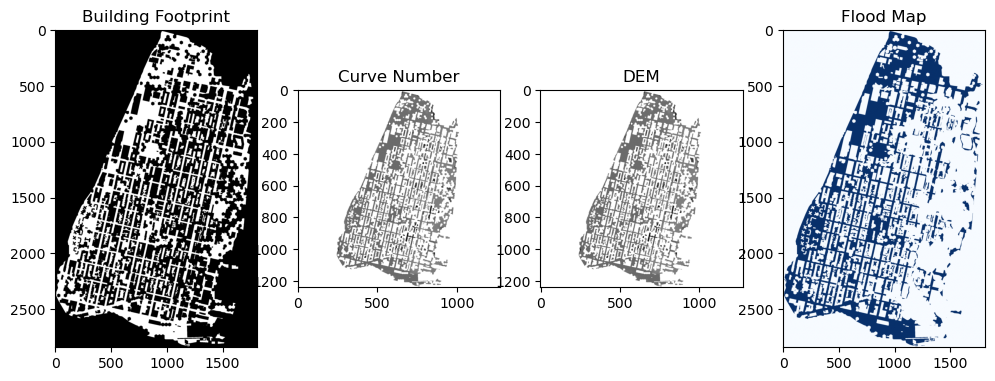

In [8]:
# Visualize a sample in the Dataset 
sample = dataset[3]
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(sample["buildings"][0], cmap="gray")
plt.title("Building Footprint")
plt.subplot(1, 4, 2)
plt.imshow(sample["curve"][0], cmap="gray")
plt.title("Curve Number")
plt.subplot(1, 4, 3)
plt.imshow(sample["DEM"][0], cmap="gray")
plt.title("DEM")
plt.subplot(1, 4, 4)
plt.imshow(sample["flood"][0], cmap="Blues")
plt.title("Flood Map")
plt.show()


In [40]:
class FloodPredictor(nn.Module):
    def __init__(self, seq_len=24, hidden_dim=64):
        super(FloodPredictor, self).__init__()

        # LSTM for rainfall sequence
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        
        # FC for rainfall duration and time of concentration
        self.duration_fc = nn.Linear(1, hidden_dim)
        self.tc_fc = nn.Linear(1, hidden_dim)

        # CNN for Curve Number
        self.curve_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for DEM
        self.DEM_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for building map
        self.building_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Convolution to map fused temporal features to a spatial map
        self.fusion_conv = nn.Conv2d(hidden_dim * 3, 1, kernel_size=1)

        # Decoder CNN to predict flood map
        self.decoder = nn.Sequential(
            nn.Conv2d(97, 32, kernel_size=3, padding=1),  # 32 each from 3 encoders + 1 fused map
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, rainfall, duration, curve_num, DEM, time_conc, buildings):
        B = rainfall.size(0)
        target_H, target_W = buildings.shape[-2], buildings.shape[-1]

        # Encode rainfall sequence
        lstm_out, _ = self.lstm(rainfall)  # (B, seq_len, hidden_dim)
        rainfall_feat = lstm_out[:, -1, :]  # (B, hidden_dim)

        # Encode duration and time of concentration
        duration_feat = F.relu(self.duration_fc(duration))  # (B, hidden_dim)
        tc_feat = F.relu(self.tc_fc(time_conc))             # (B, hidden_dim)

        # Concatenate and expand to spatial map
        fused = torch.cat([rainfall_feat, duration_feat, tc_feat], dim=1)  # (B, 3*hidden_dim)
        fused = fused.unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)
        fused = fused.expand(-1, -1, target_H, target_W)  # (B, C, H, W)
        fused = self.fusion_conv(fused)  # (B, 1, H, W)

        # Encode spatial features
        curve_feat = self.curve_encoder(curve_num)        # (B, 32, H, W)
        DEM_feat = self.DEM_encoder(DEM)                  # (B, 32, H, W)
        building_feat = self.building_encoder(buildings)  # (B, 32, H, W)

        # Resize if needed (you could remove this if inputs are guaranteed to match)
        curve_feat = F.interpolate(curve_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)
        DEM_feat = F.interpolate(DEM_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)
        building_feat = F.interpolate(building_feat, size=(target_H, target_W), mode='bilinear', align_corners=False)

        # Combine features
        combined = torch.cat([building_feat, curve_feat, DEM_feat, fused], dim=1)  # (B, 97, H, W)

        # Predict flood map
        flood_pred = self.decoder(combined).squeeze(1)  # (B, H, W)
        return flood_pred


In [22]:
# Modified loss function

def masked_bce_loss(pred, target, mask):
    # Compute element-wise BCE loss
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    
    # Apply mask
    masked_bce = bce * mask

    # Avoid division by zero
    loss = masked_bce.sum() / mask.sum().clamp(min=1.0)
    return loss


In [41]:
# Setup
model = FloodPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.BCELoss()
num_epochs = 10

# Dataloader
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Creating mask for loss function
mask = test_dataset[1]["buildings"]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        rain = batch['rainfall'].to(device)
        dur = batch['duration'].to(device)
        curve = batch['curve'].to(device)
        DEM = batch['DEM'].to(device)
        tc = batch['tc'].to(device)
        build = batch['buildings'].to(device)
        flood = batch['flood'].to(device).squeeze(1).float()
        mask = batch['buildings'].to(device).squeeze(1).float()

        pred = model(rain, dur, curve, DEM, tc, build)
        loss = masked_bce_loss(pred, flood, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: -3687793295360.0000
Epoch 2, Loss: -71253691990016.0000
Epoch 3, Loss: -71253691990016.0000
Epoch 4, Loss: -71253691990016.0000
Epoch 5, Loss: -71253691990016.0000
Epoch 6, Loss: -71253691990016.0000
Epoch 7, Loss: -71253691990016.0000
Epoch 8, Loss: -71253691990016.0000
Epoch 9, Loss: -71253691990016.0000
Epoch 10, Loss: -71253691990016.0000


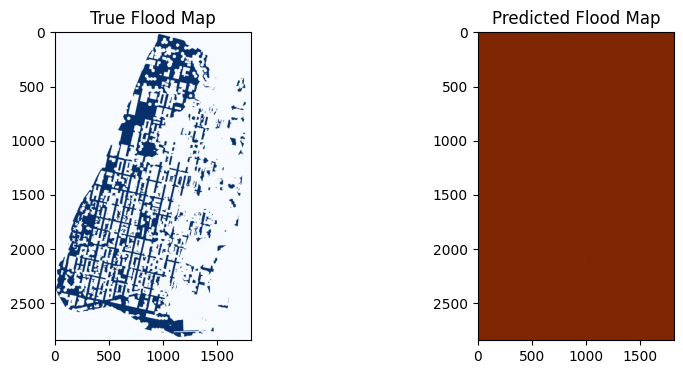

In [42]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[0]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0).to(device), sample["duration"].unsqueeze(0).to(device), sample["curve"].unsqueeze(0).to(device), 
                 sample["DEM"].unsqueeze(0).to(device), sample["tc"].unsqueeze(0).to(device), sample["buildings"].unsqueeze(0).to(device))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"].squeeze().cpu().numpy(), cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze().cpu().numpy(), cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


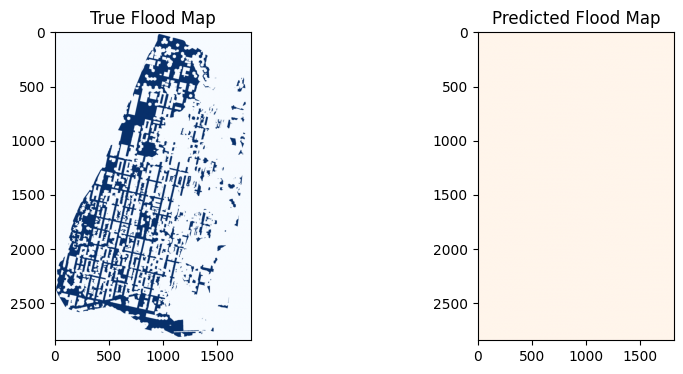

In [43]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[0]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0).to(device), sample["duration"].unsqueeze(0).to(device), sample["curve"].unsqueeze(0).to(device), 
                 sample["DEM"].unsqueeze(0).to(device), sample["tc"].unsqueeze(0).to(device), sample["buildings"].unsqueeze(0).to(device))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"].squeeze().cpu().numpy(), cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)
plt.imshow(predicted_flood_map, cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()

In [20]:
def evaluate_model(model, dataset, threshold=0.5):
    
    '''
    calculate flood map for test dataset and copute confusion matrix, accuracy, precision, and recall.
    
    '''
    
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            rain = sample["rainfall"].unsqueeze(0)
            dur = sample["duration"].unsqueeze(0)
            curve = sample["curve"].unsqueeze(0)
            time_conc = sample["time_conc"].unsqueeze(0)
            build = sample["buildings"].unsqueeze(0)

            pred = model(rain, dur, curve, time_conc, build)
            pred_binary = (pred.squeeze().cpu().numpy() > threshold).astype(int)
            true_binary = sample["flood"].numpy().astype(int)

            y_pred_all.extend(pred_binary.flatten())
            y_true_all.extend(true_binary.flatten())

    # Convert to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    return cm, acc, prec, rec, y_true_all, y_pred_all


In [21]:
def plot_confusion_matrix(y_true, y_pred, labels=["Not Flooded", "Flooded"], title="Confusion Matrix"):
    '''
    Visualize the cofusion matrix
    
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color("black")
        
    plt.tight_layout()
    plt.show()


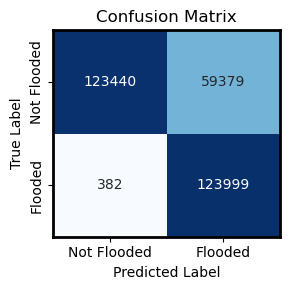

Confusion Matrix:
 [[123440  59379]
 [   382 123999]]
Accuracy:  0.805
Precision: 0.676
Recall:    0.997


In [22]:
cm, acc, prec, rec, y_true_all, y_pred_all = evaluate_model(model, test_dataset)
plot_confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")